In [4]:
import pickle
import torch
from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float16):
        super(AutoEncoder, self).__init__()
        # create decoder using float16 to save memory
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=False)
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        self.encoder = nn.Sequential(
            nn.Linear(activation_size, n_dict_components).to(t_type),
            nn.ReLU()
        )
        
    def forward(self, x):
        c = self.encoder(x)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)
    
        x_hat = self.decoder(c)
        return x_hat, c
    
    @property
    def device(self):
        return next(self.parameters()).device
    
# Initialize an empty list to store the loaded data
autoencoders = []
av_activations = []

# Loop over the file indices
for i in range(20):  # 20 because you said up to 19, range stops one step before the stop argument
    # Create the file path
    file_path_auto = f"outputs/20230624-035145/minirun{i}/autoencoders.pkl"
    file_path_activation = f"outputs/20230624-035145/minirun{i}/av_activations.pkl"

    # Open the file and load the data
    with open(file_path_auto, 'rb') as file:
        autoencoders.append(pickle.load(file))

    with open(file_path_activation, 'rb') as file:
        av_activations.append(pickle.load(file))

In [109]:
dictionary_2k = [ae[0][0].decoder.weight.data.T for ae in autoencoders]
dictionary_4k = [ae[0][1].decoder.weight.data.T for ae in autoencoders]
dictionary_8k = [ae[0][2].decoder.weight.data.T for ae in autoencoders]

av_2k = [act[0][0] for act in av_activations]
av_4k = [act[0][1] for act in av_activations]
av_8k = [act[0][2] for act in av_activations]

0.4478309

In [83]:
from scipy.optimize import linear_sum_assignment
import numpy as np
def run_mmcs_with_larger(smaller_dict, larger_dict, device):
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    larger_dict = larger_dict.to(device)
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]
    
    return max_cosine_similarities, row_ind, col_ind


In [84]:
mcs, row, col = run_mmcs_with_larger(dictionary_2k[0], dictionary_4k[0], device)

In [97]:
time_series_N

19

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
time_series_N = len(dictionary_2k) -1
neurons = dictionary_2k[i].shape[0]
self_sim = np.zeros((time_series_N, neurons))
self_sim_larger = np.zeros((time_series_N, neurons))
mcs = np.zeros((time_series_N, neurons))
for i in range(time_series_N):
    print(i)
    mcs[i], _, col = run_mmcs_with_larger(dictionary_2k[i], dictionary_4k[i], device)
    # Index larger self_sim by col
    self_sim_larger[i] =  torch.nn.functional.cosine_similarity(dictionary_4k[i].to(device), dictionary_4k[i+1].to(device), dim=1).cpu().numpy()[col]
    self_sim[i] = torch.nn.functional.cosine_similarity(dictionary_2k[i].to(device), dictionary_2k[i+1].to(device), dim=1).cpu().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [132]:
av_2k_np = np.array(av_2k)
av_4k_np = np.array(av_4k)
av_8k_np = np.array(av_8k)

In [133]:
av_2k_np.shape

(20, 2048)

/tmp/ipykernel_46800/3814189286.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


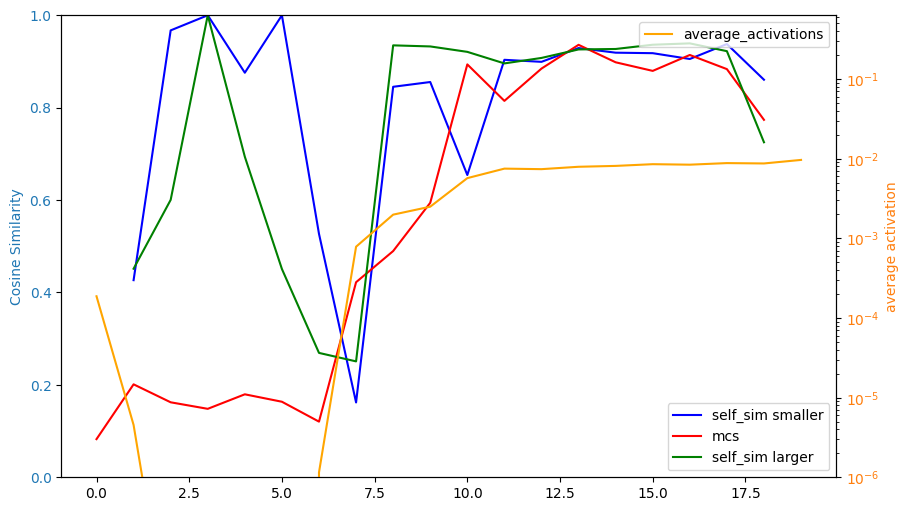

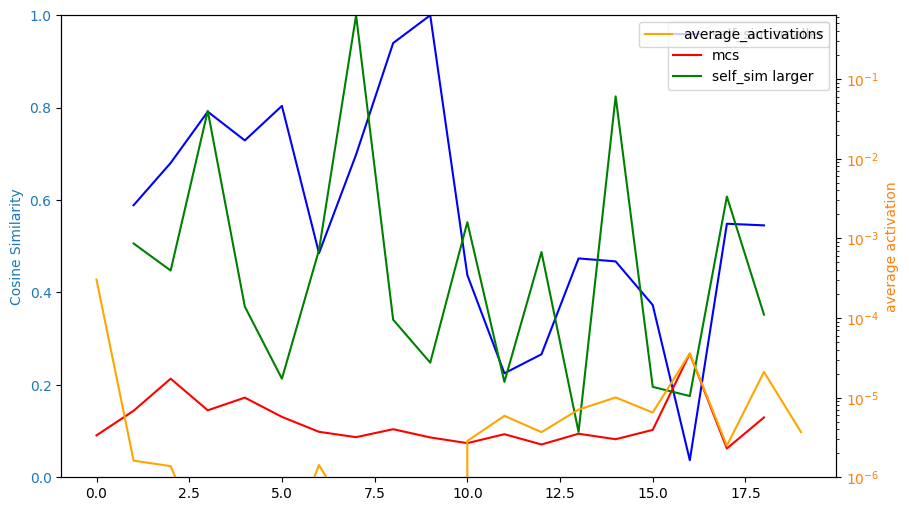

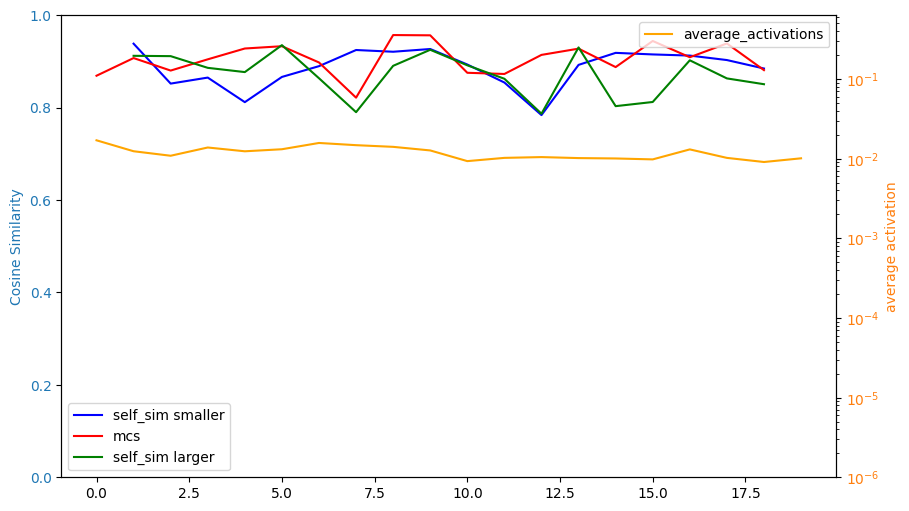

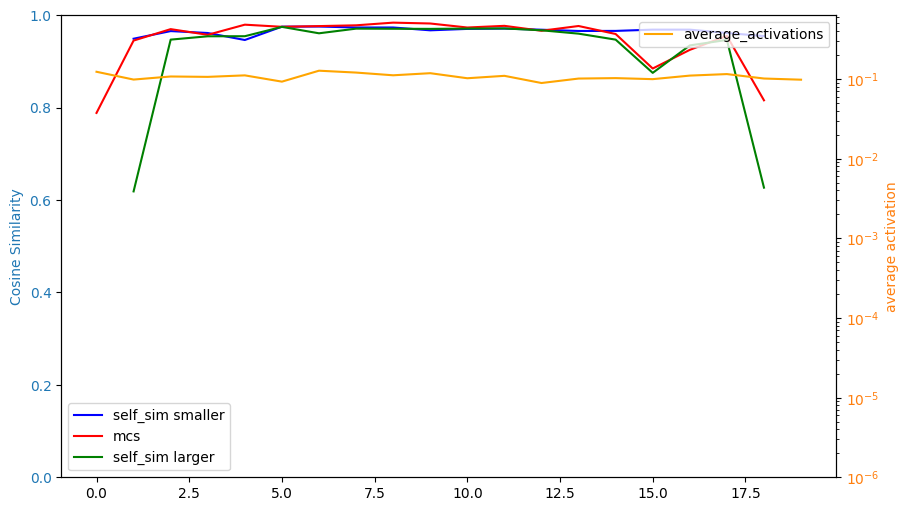

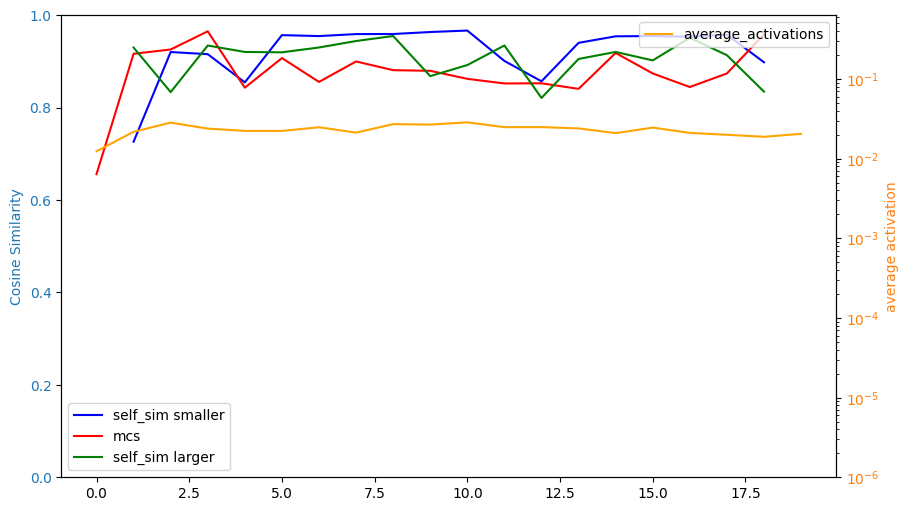

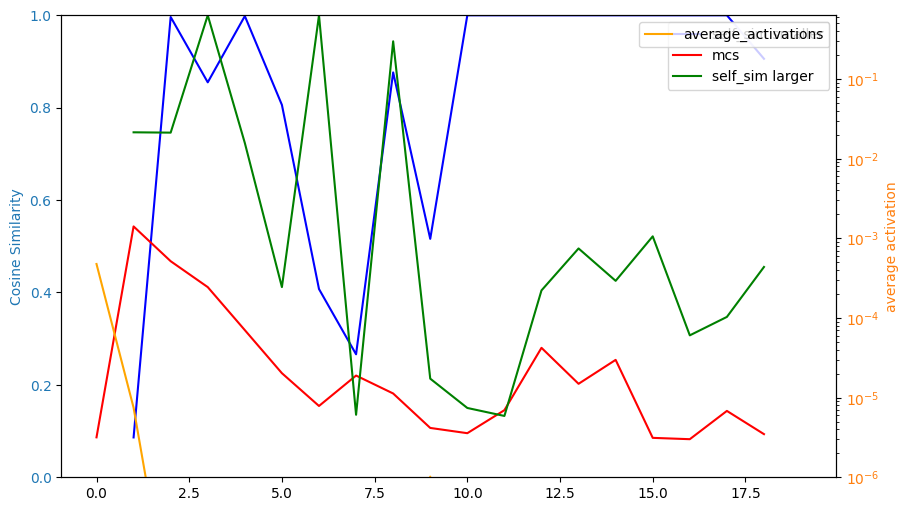

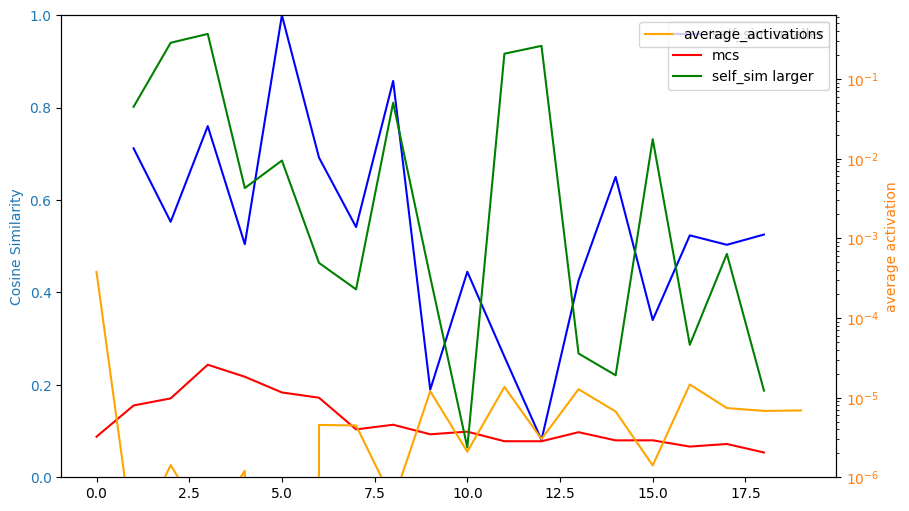

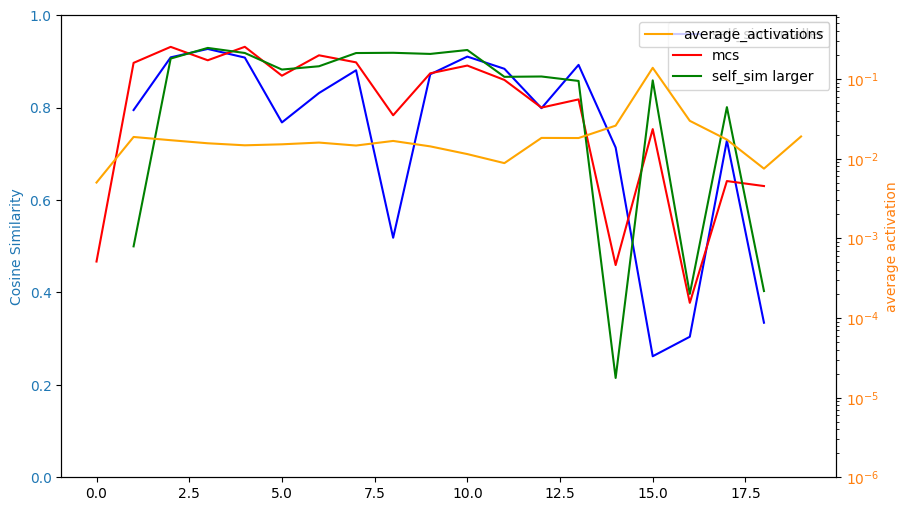

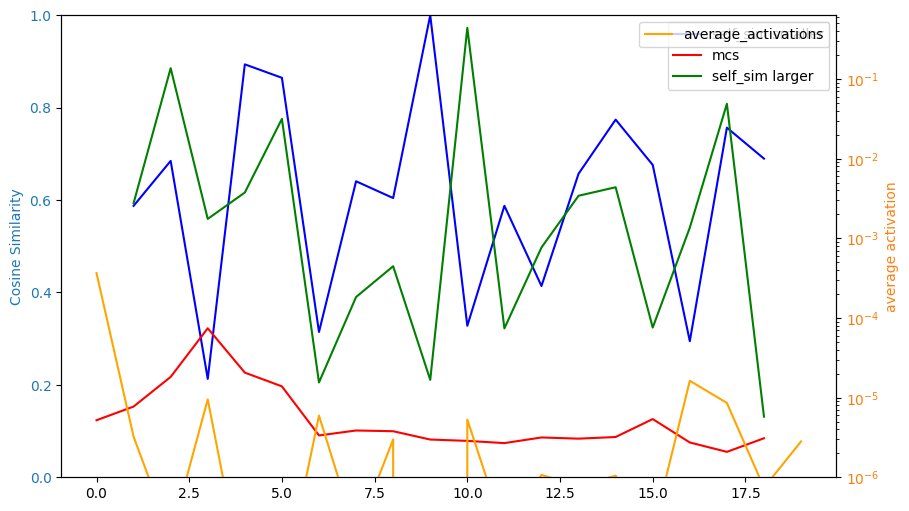

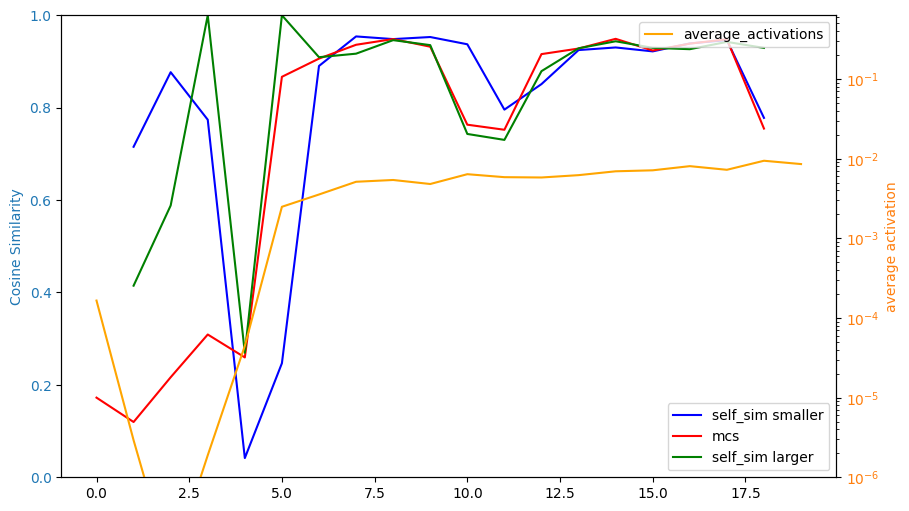

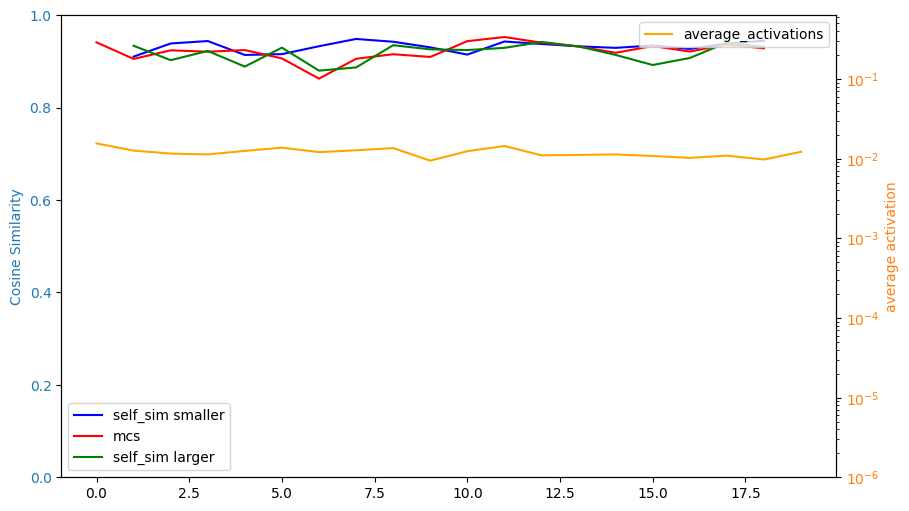

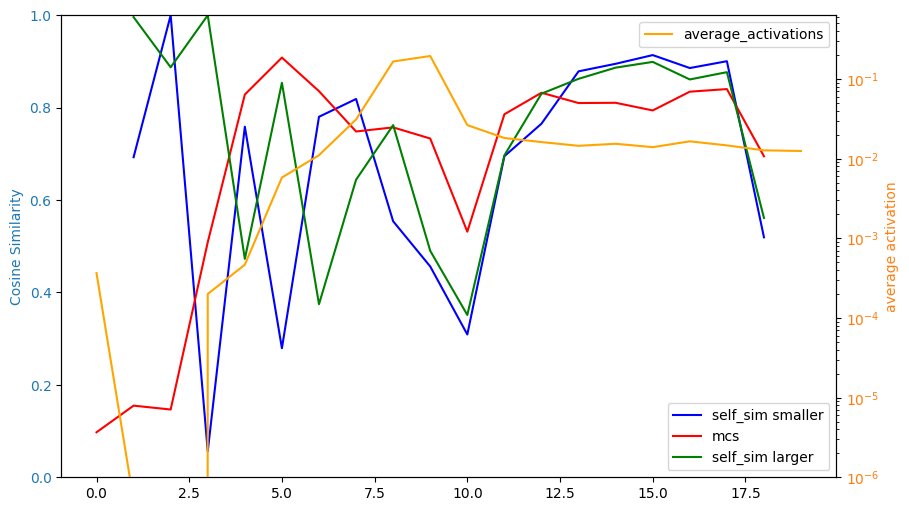

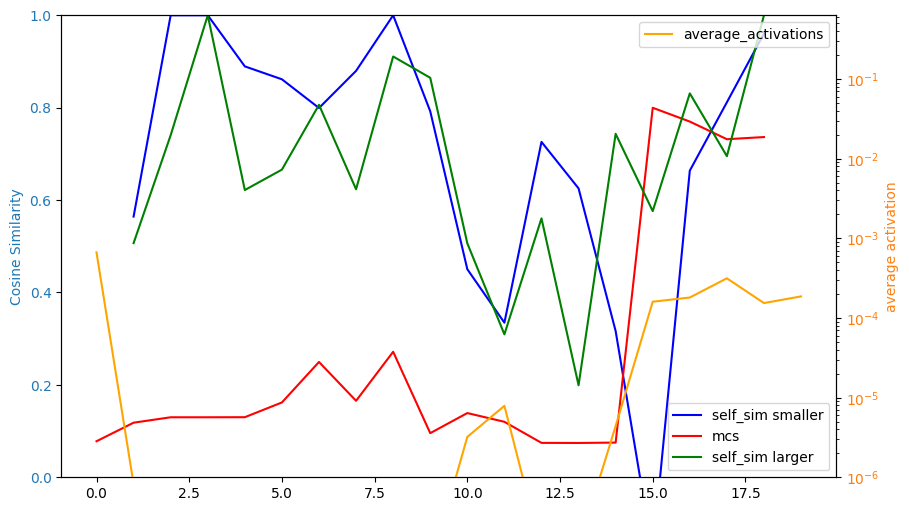

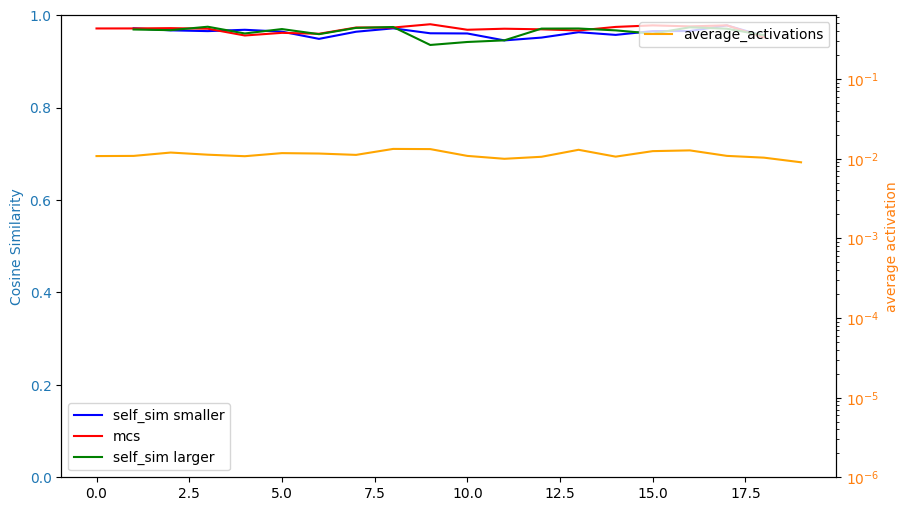

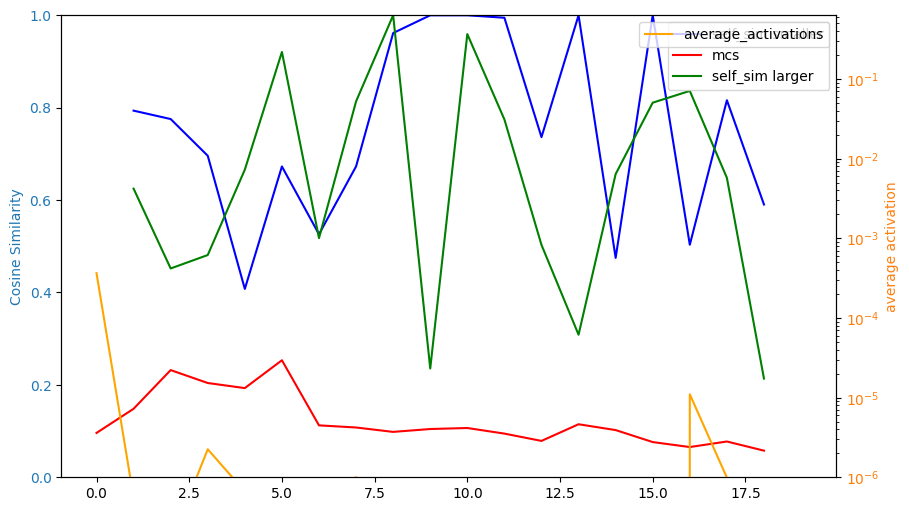

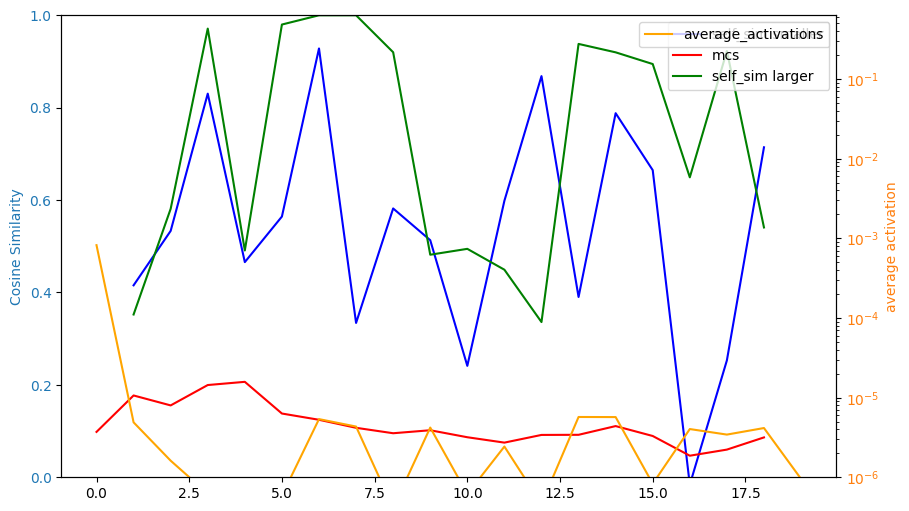

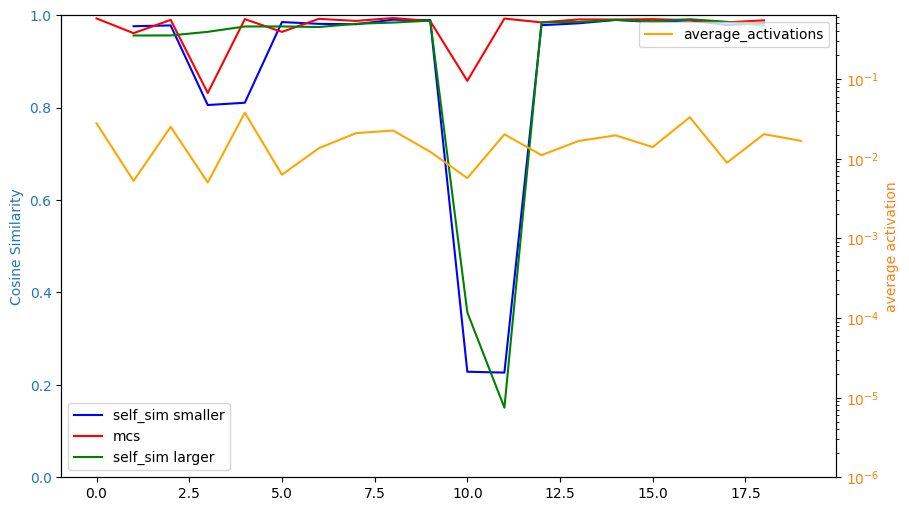

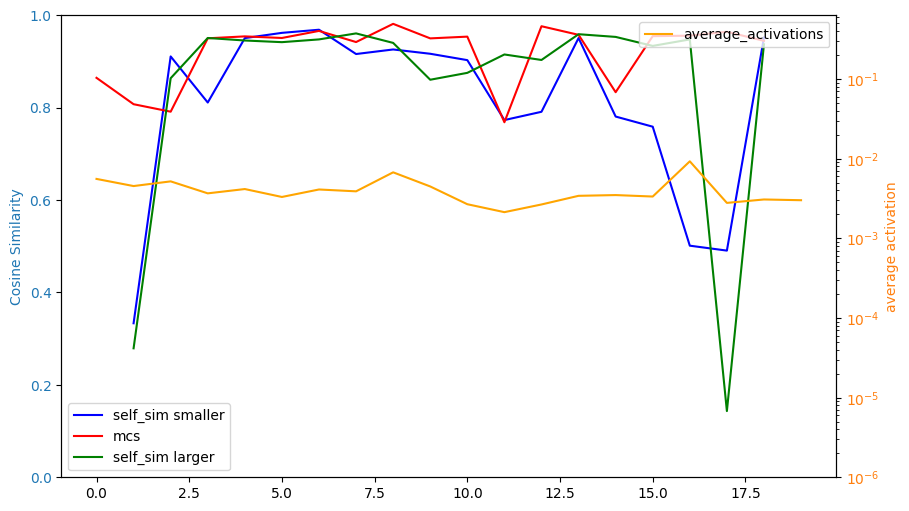

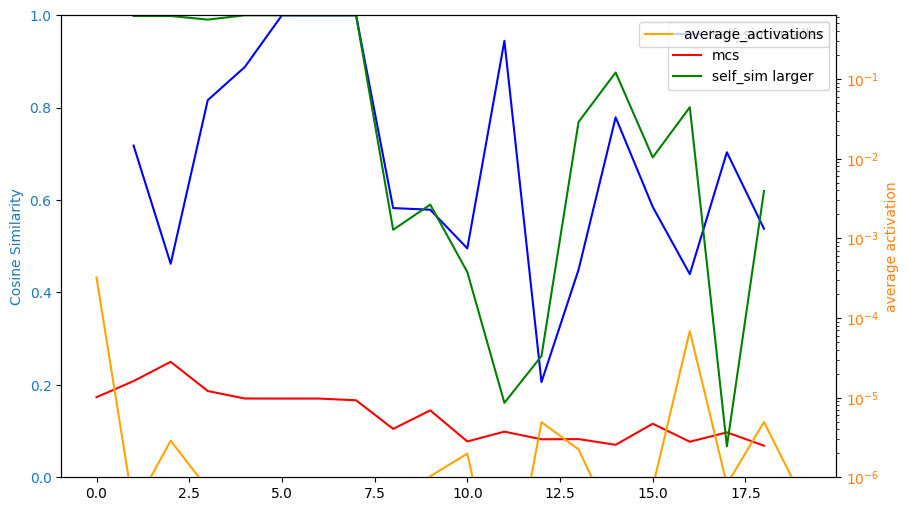

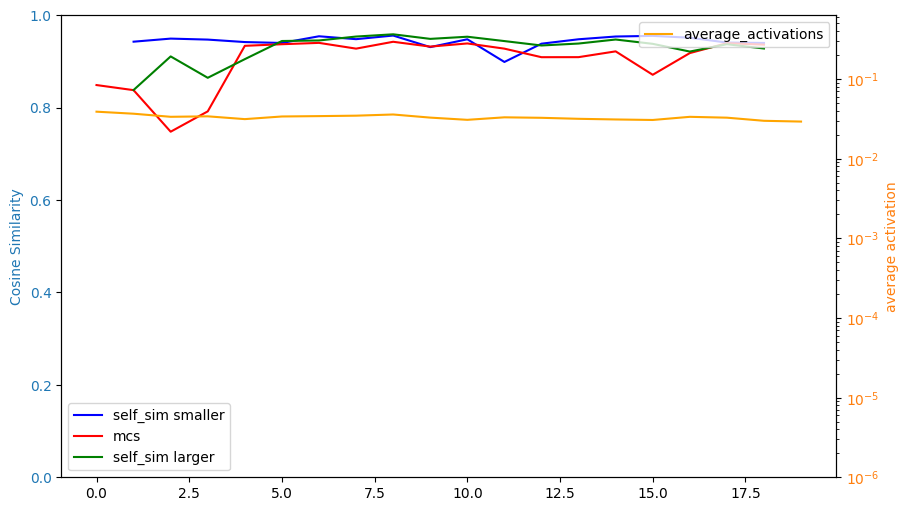

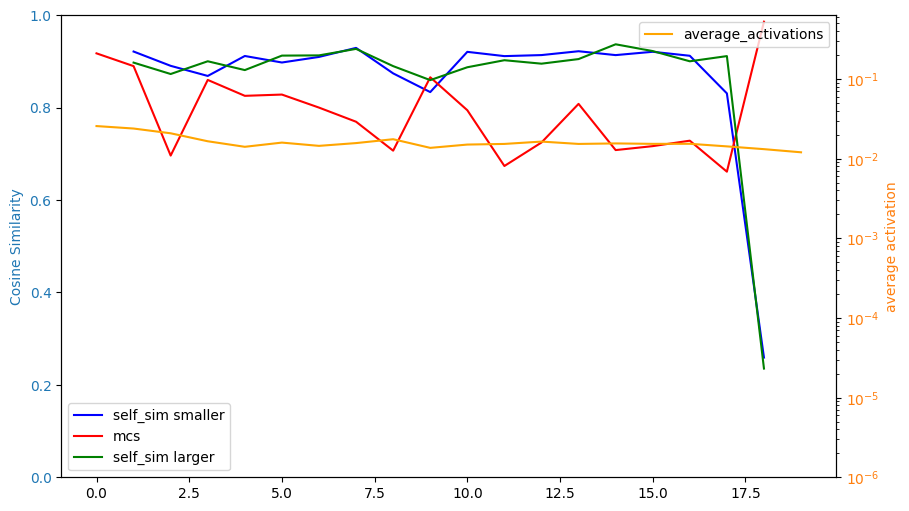

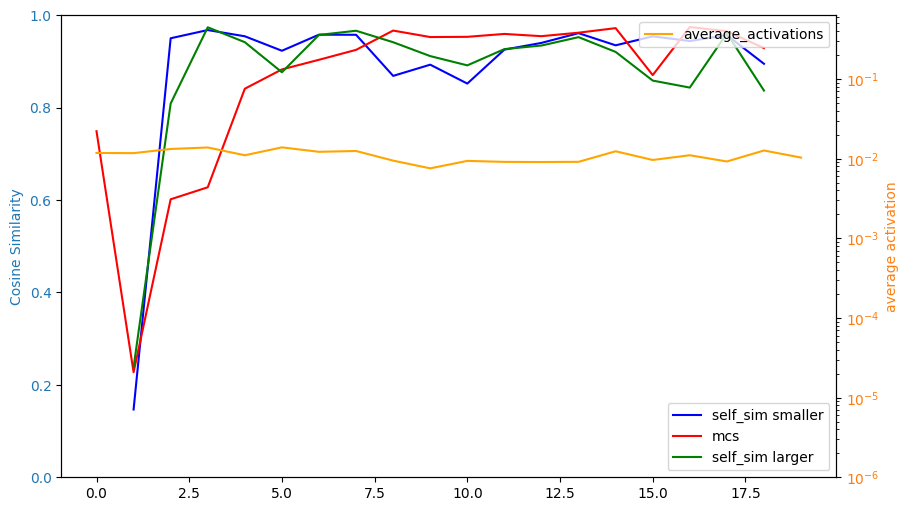

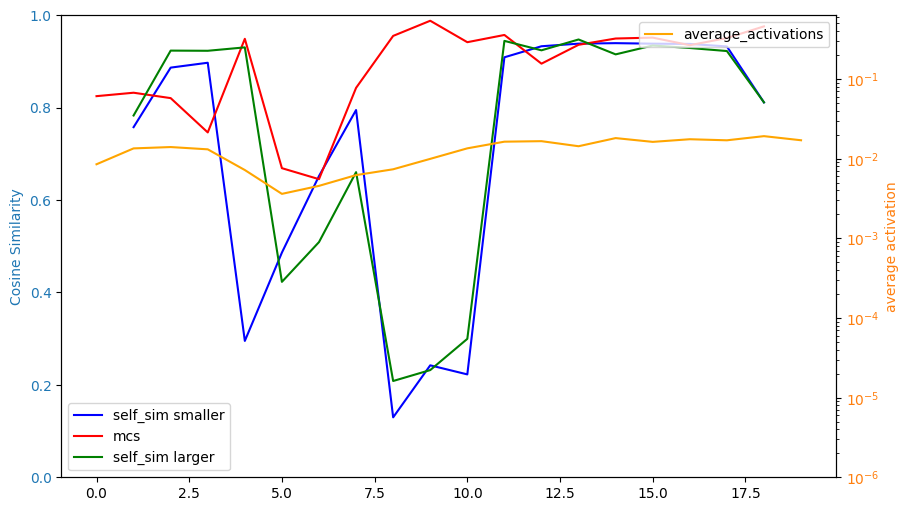

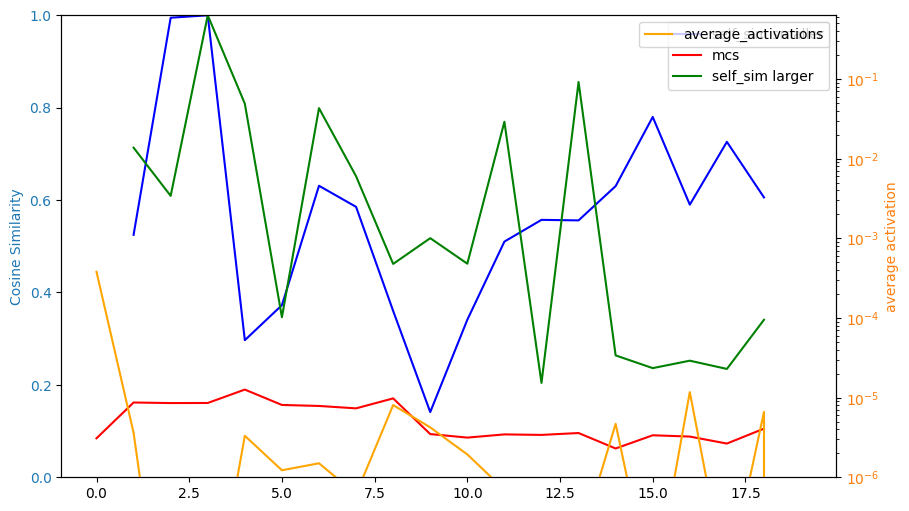

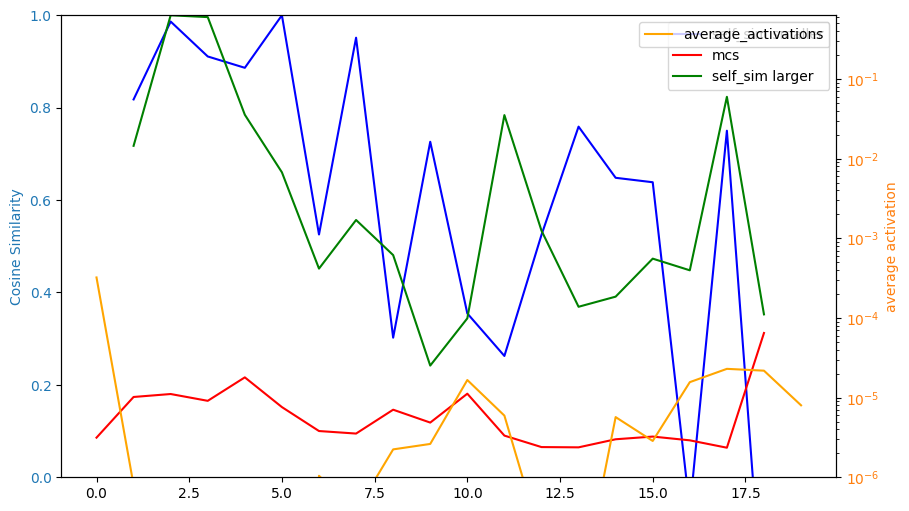

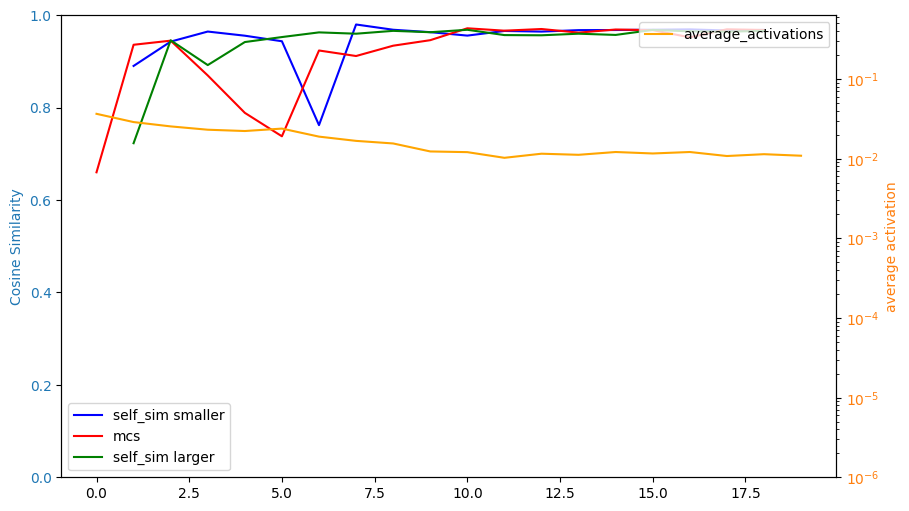

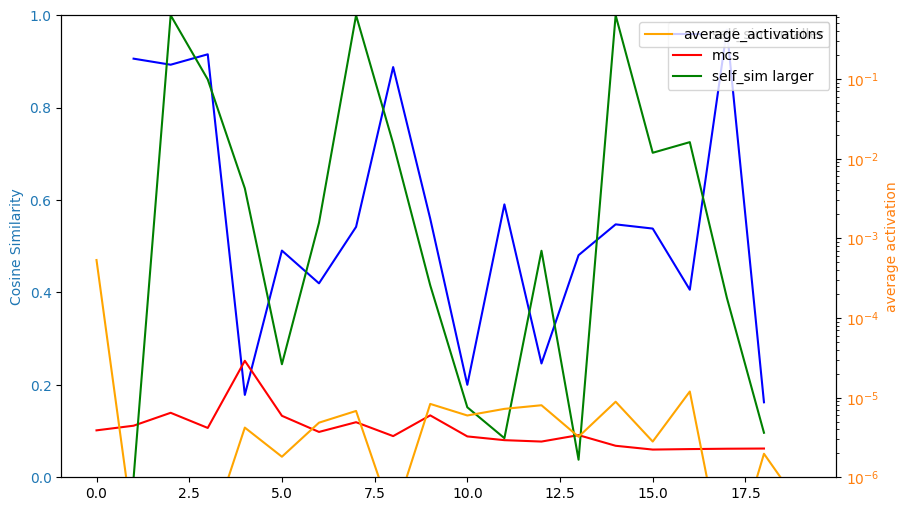

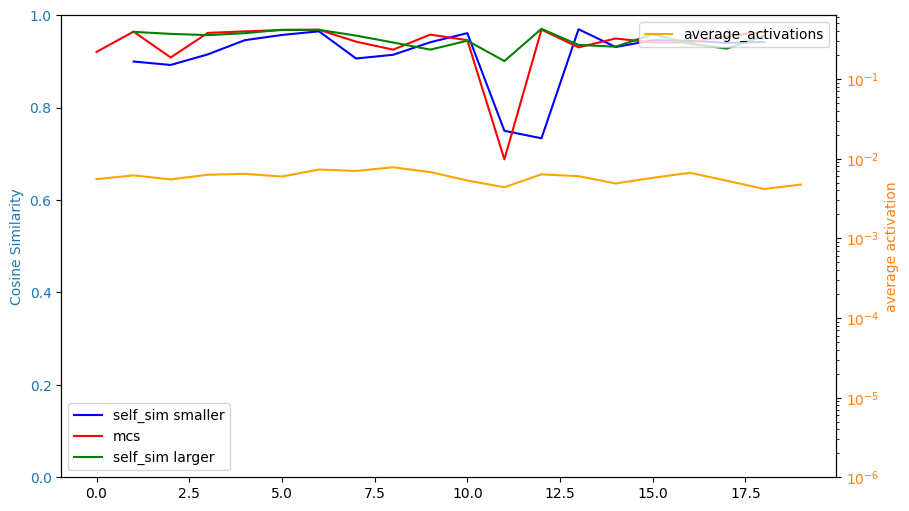

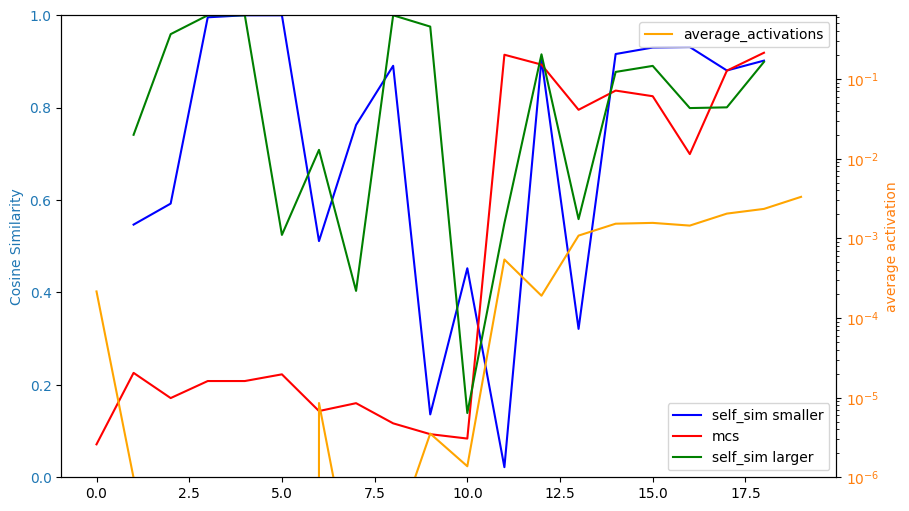

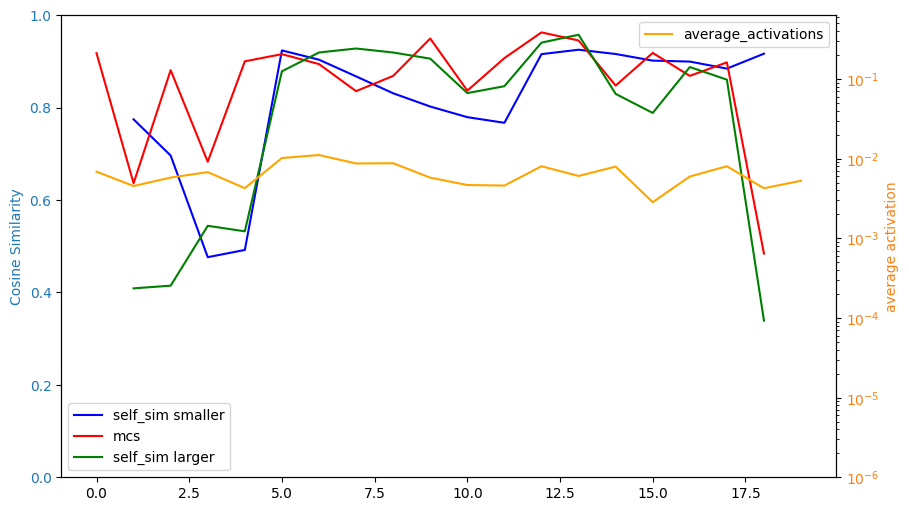

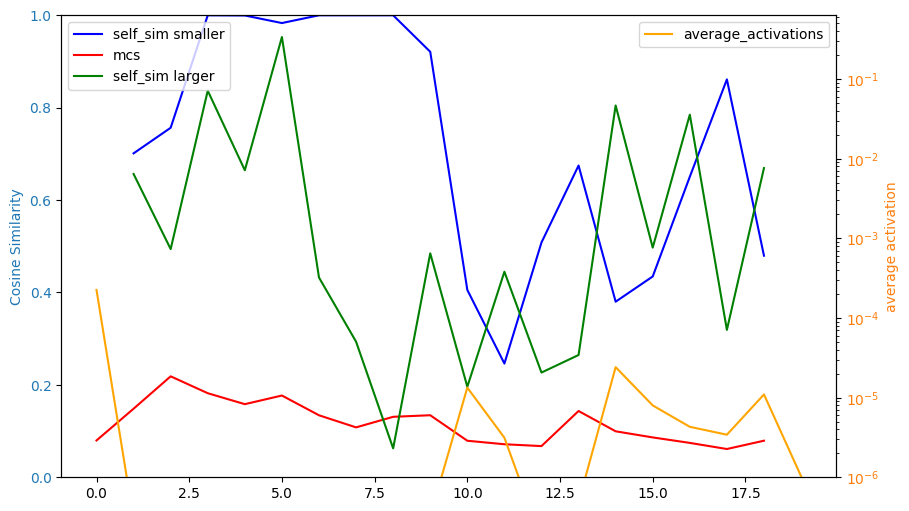

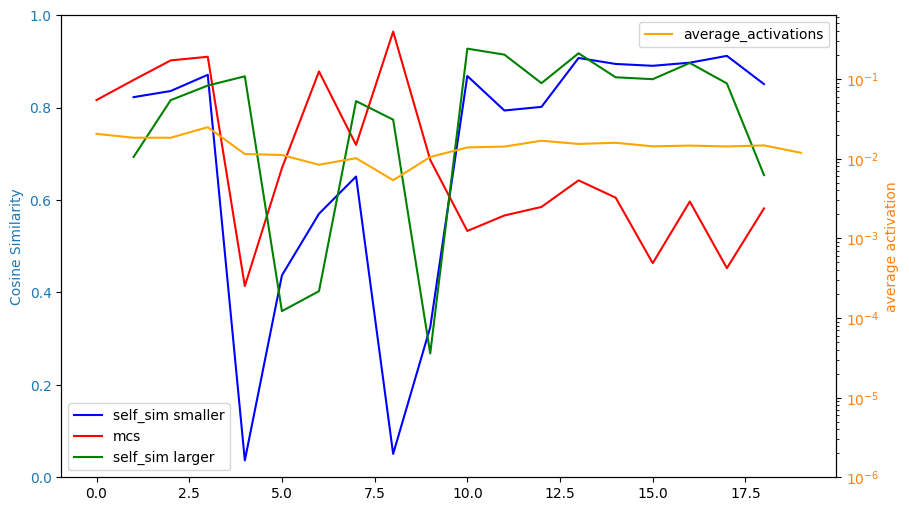

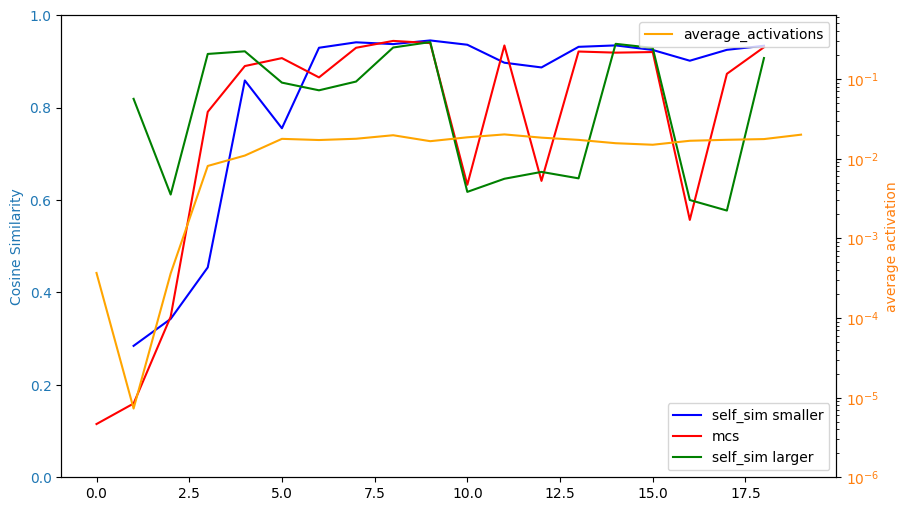

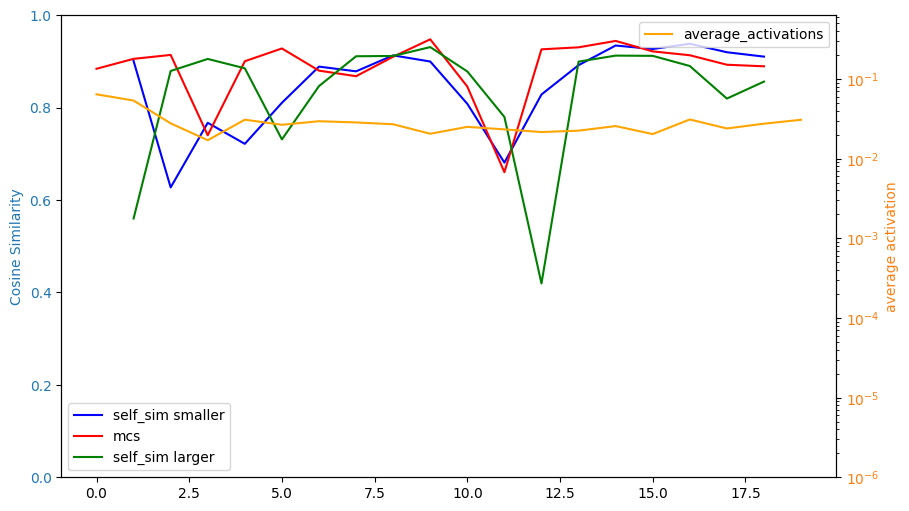

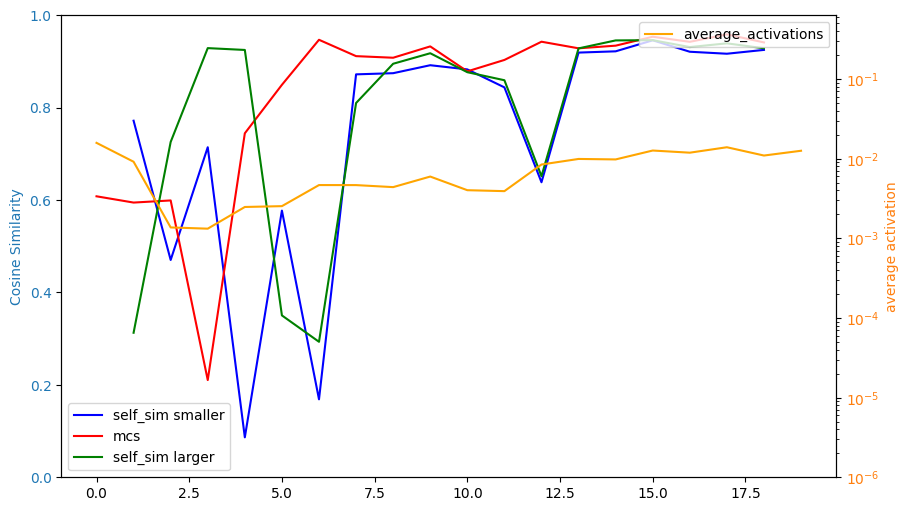

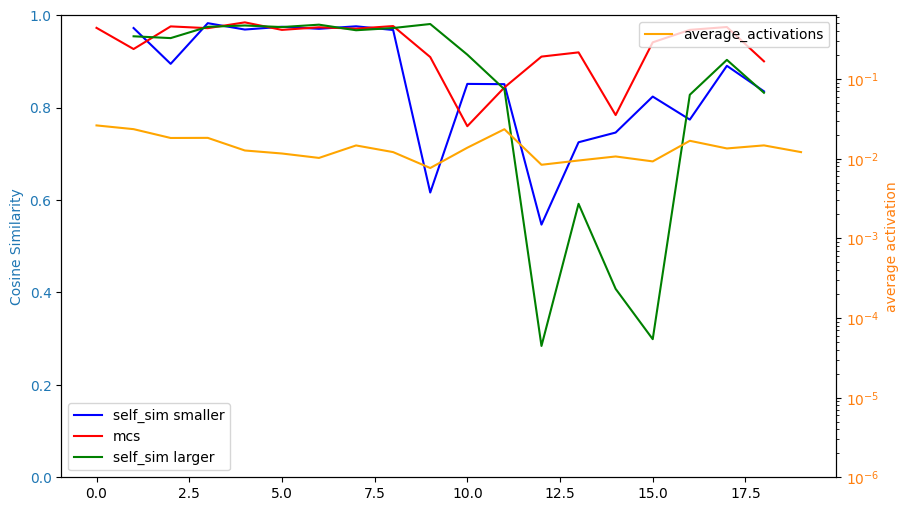

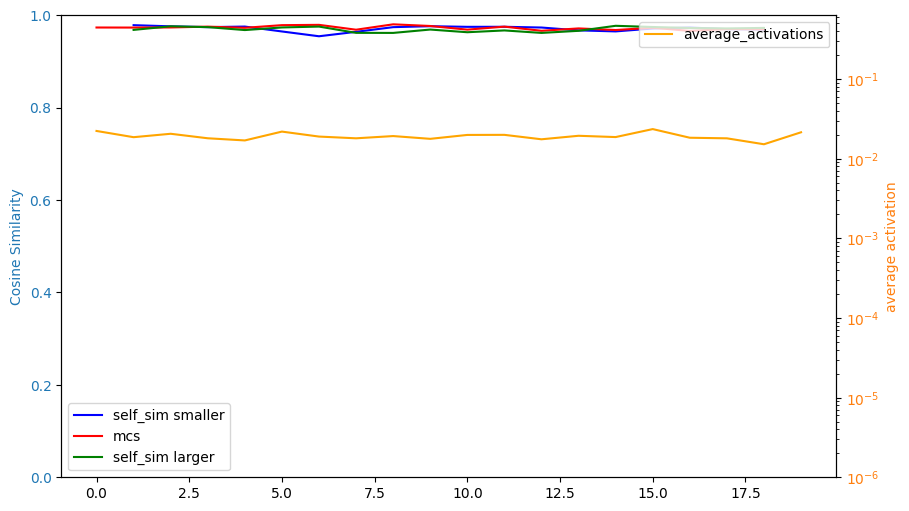

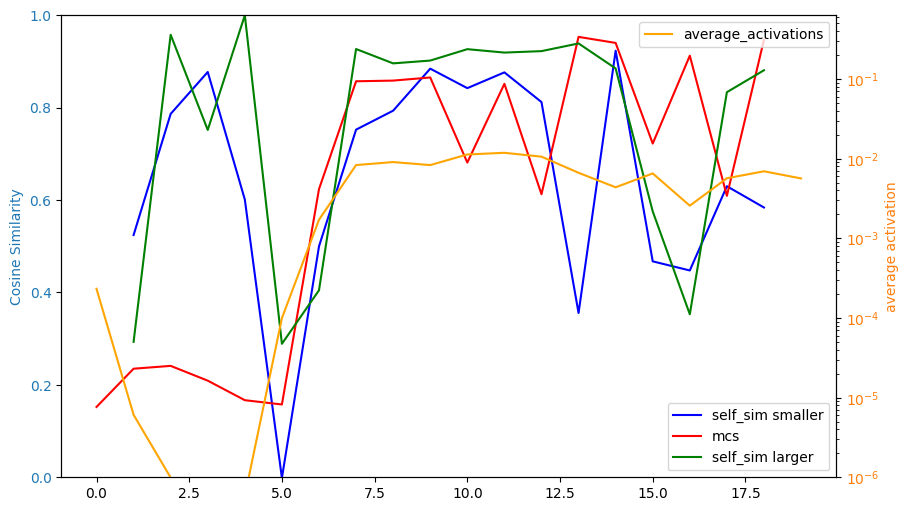

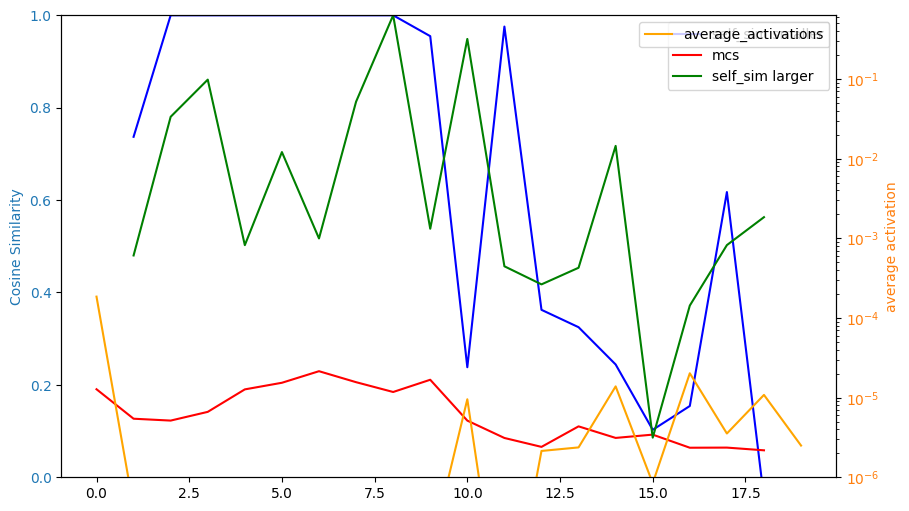

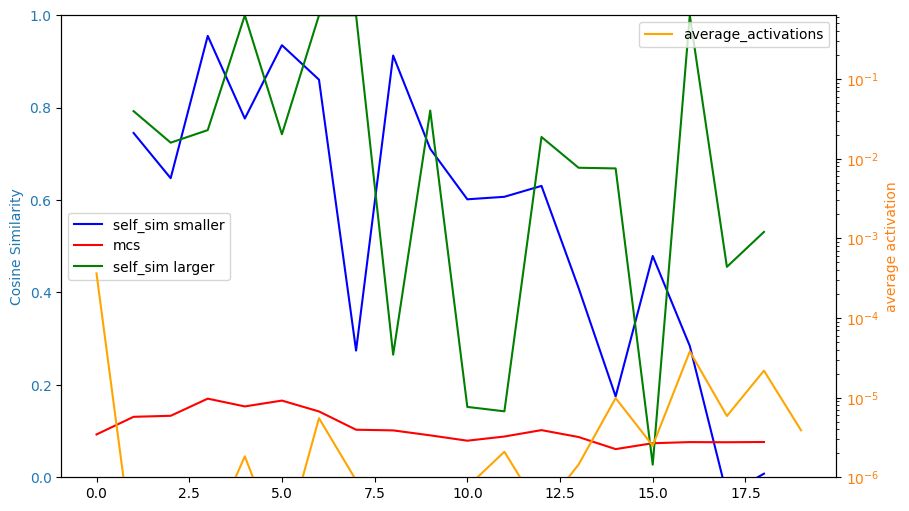

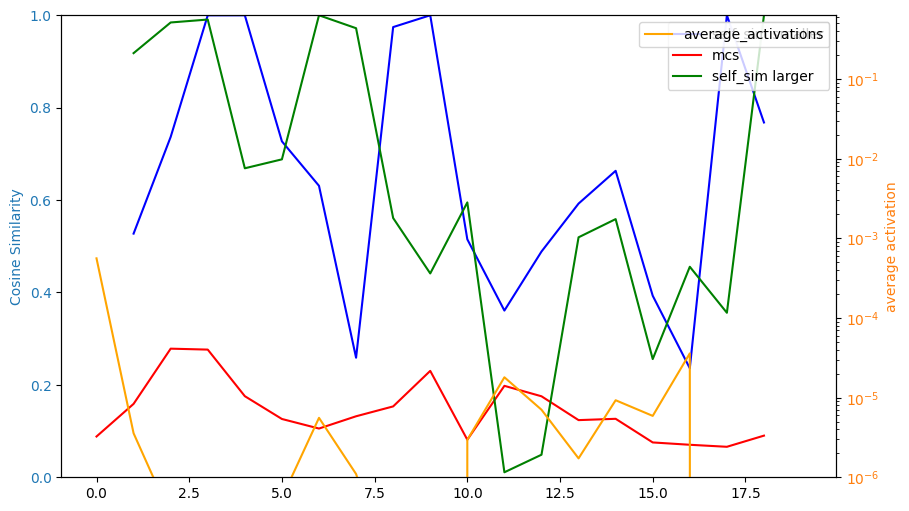

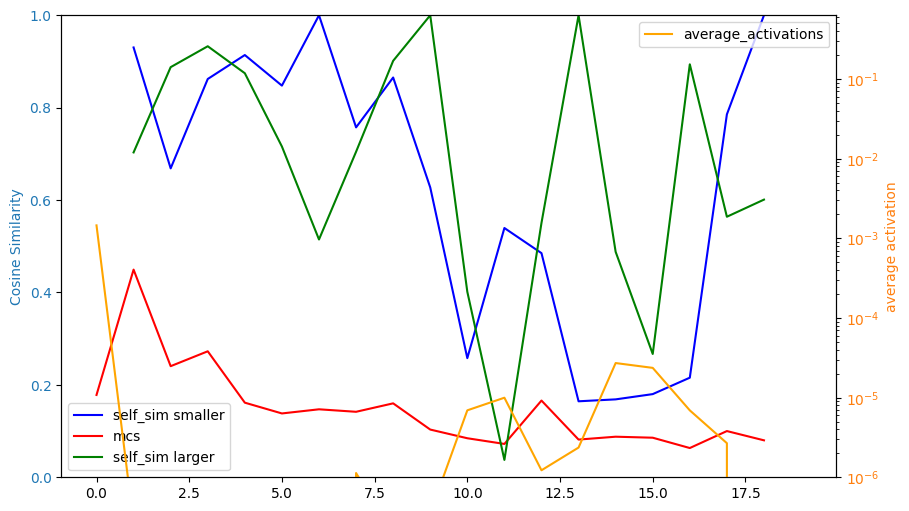

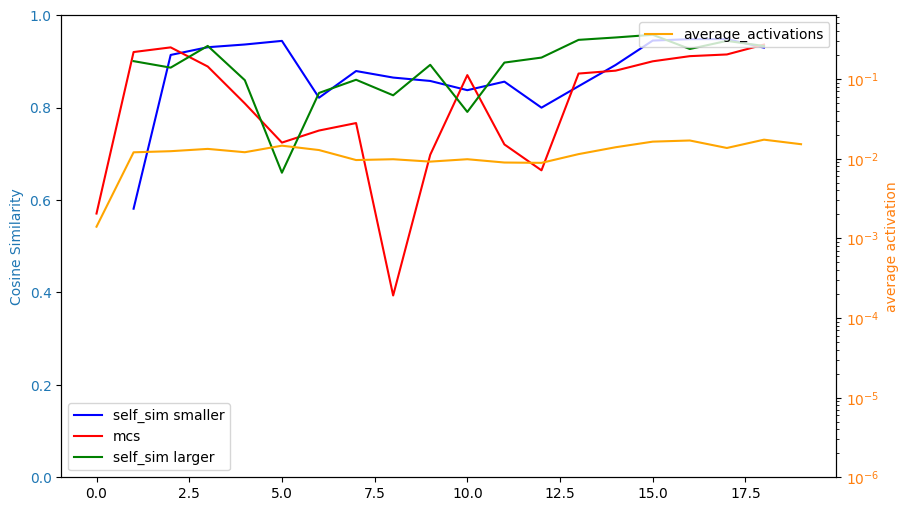

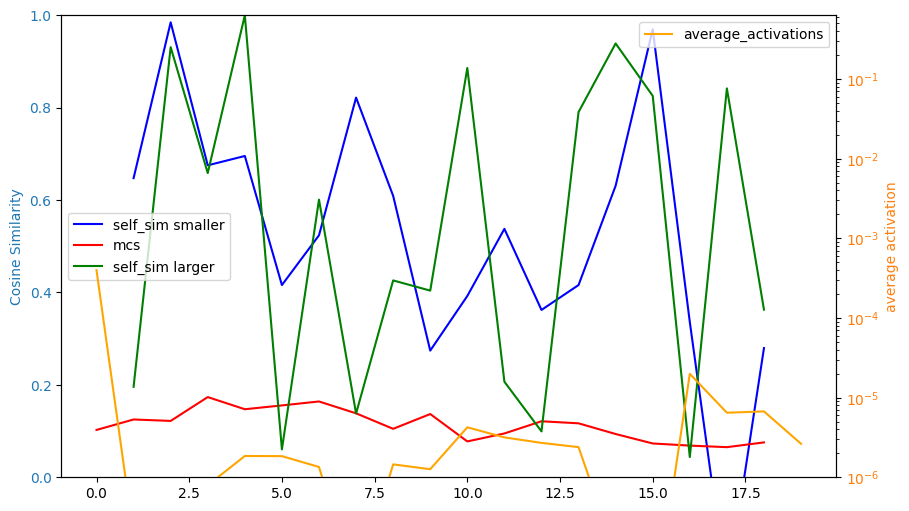

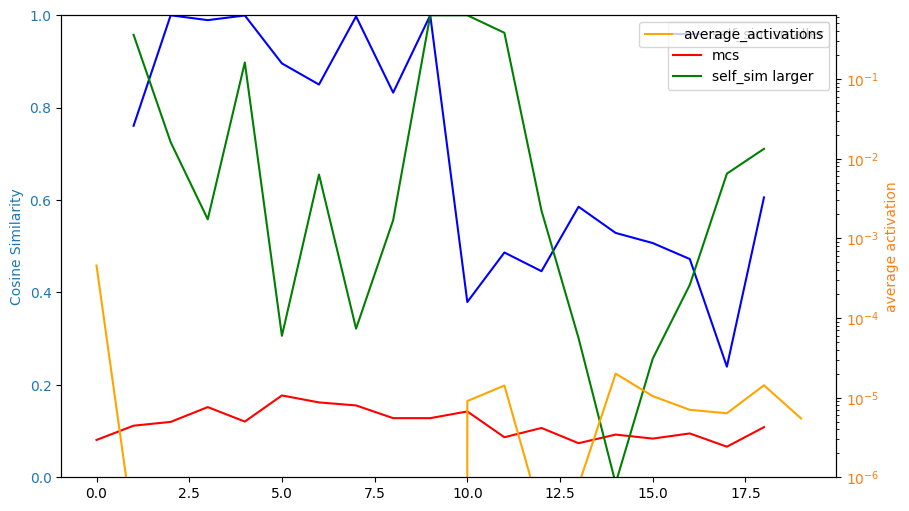

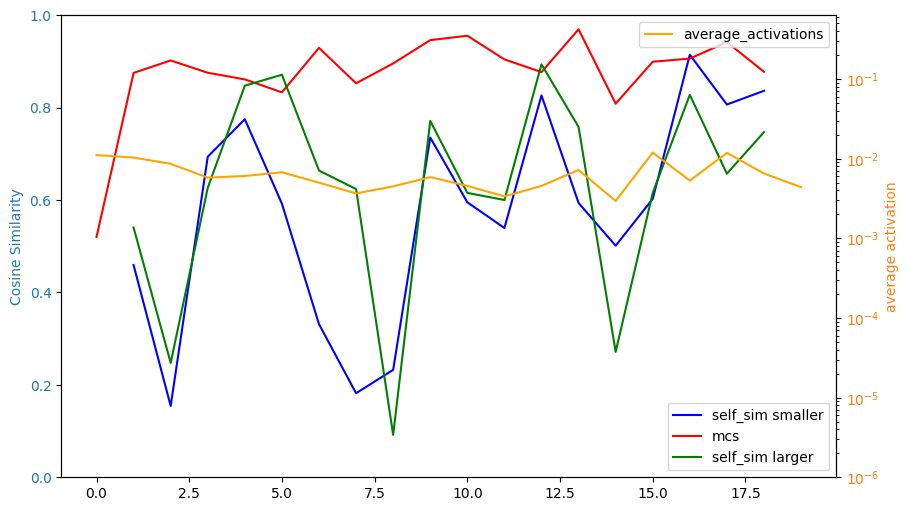

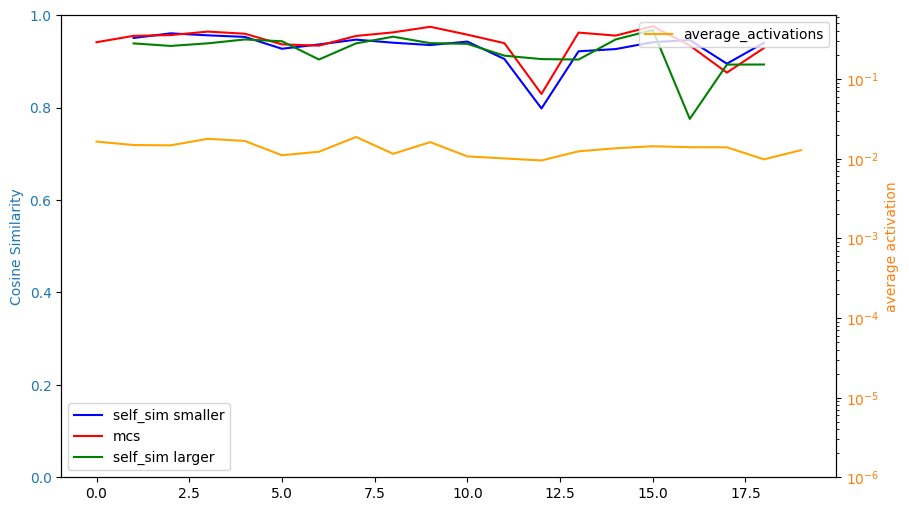

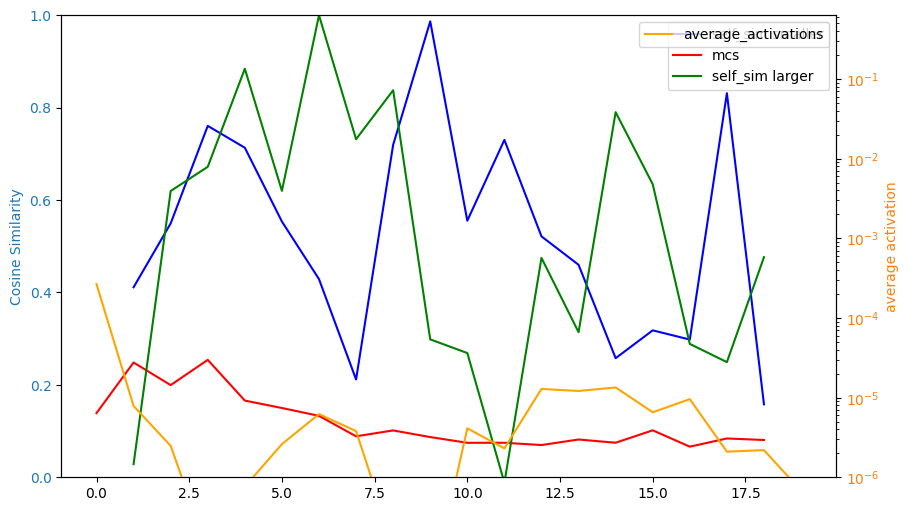

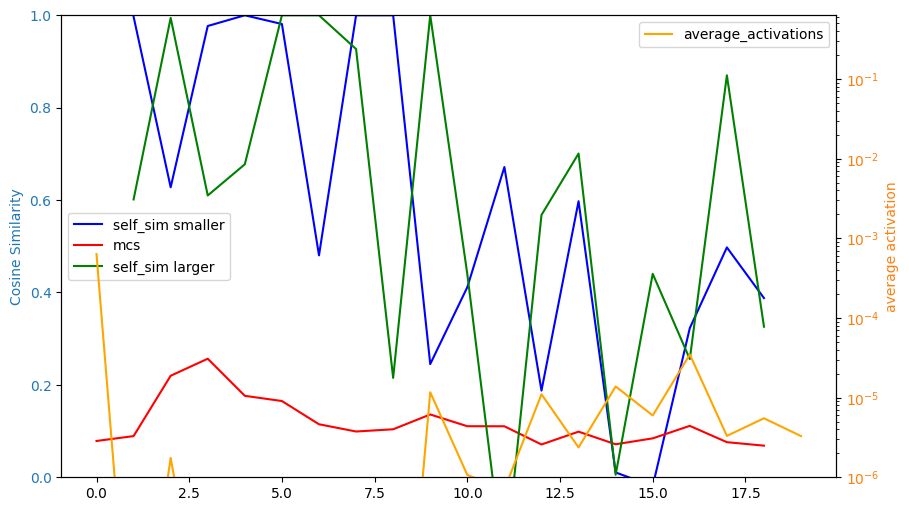

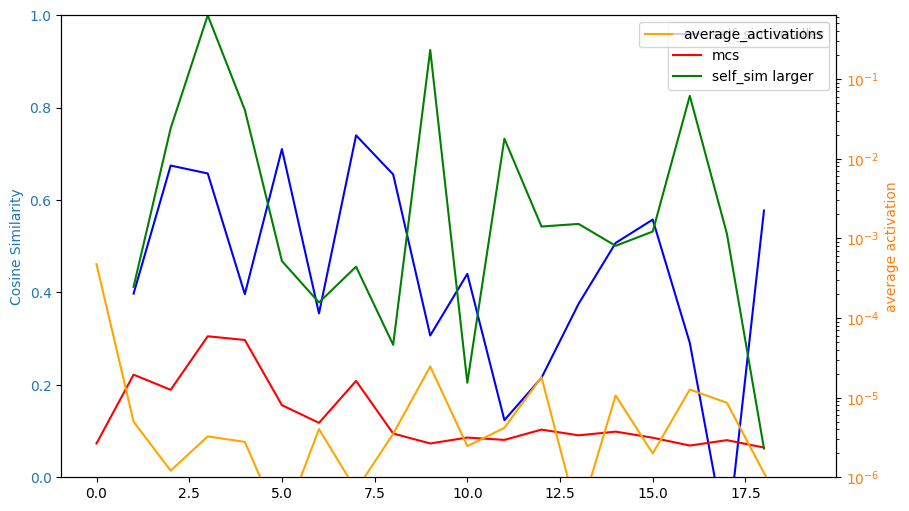

In [154]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
time_steps = np.arange(time_series_N)
time_steps_self_sim = np.arange(1, time_series_N)
N = 0
max_activation = av_2k_np.max()
for N in range(N, N + 50):
    fig, ax = plt.subplots(figsize=(10, 6))
    # set ylim to 0, 1
    ax.set_ylim(0, 1)
    plt.plot(time_steps_self_sim, self_sim[:-1,N], label="self_sim smaller", color="blue")
    plt.plot(time_steps, mcs[:,N], label="mcs", color="red")
    plt.plot(time_steps_self_sim, self_sim_larger[:-1,N], label="self_sim larger", color="green")
    color = 'tab:blue'
    ax.set_ylabel('Cosine Similarity', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend()
    ax2 = ax.twinx()  
    ax2.plot(av_2k_np[:,N], label="average_activations", color="orange")
    ax2.set_yscale('log')
    ax2.set_ylim(1e-6, max_activation)
    color = 'tab:orange'
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('average activation', color=color)
    ax2.legend()    

In [50]:
(mcs > 0.6).sum(dim=0).count_nonzero()

tensor(0)

In [10]:
time_steps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [44]:
time_steps.shape, self_sim_np.shape, mcs_np.shape

((19,), (19, 2048), (19, 2048))

In [40]:
dictionary_2k[i].shape[0]

2048

In [25]:
d1 = torch.rand(10,2)
d2 = torch.rand(10,2)
torch.nn.functional.cosine_similarity(d1, d1, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])